In [1]:
%run 'testSkeleton_OQE_Functions.ipynb'

In [2]:
s = 120
nu_max, nu_min = 120, 100 # MHz units
inprange = nu_max - nu_min
nu_ = np.linspace(nu_min,nu_max,s)
nu, nup = np.meshgrid(nu_,nu_)
tau_ = np.fft.fftfreq(s, (nu_max-nu_min)/(s-1))
tau_f = flip(tau_)
print(tau_f[0:5])

[-2.975      -2.92541667 -2.87583333 -2.82625    -2.77666667]


In [3]:
from scipy import linalg
from scipy.stats import invgamma
import pyuvdata as uvd
uvobj = uvd.UVData()

In [4]:
FO = FOp(s) # fourier operator

In [139]:
# reading in various sims

at1,at2 = 0,1
simfile = '/home/kennedy/sims/viscatBCpoints.uvh5' 
faintfile = '/home/kennedy/sims/viscatBC15jy.uvh5'
oldsimfile = '/home/kennedy/sims/600times/viscatBCpoints.uvh5'
oldeorfile = '/home/kennedy/sims/600times/viscatBCeor.uvh5'
ats = (at1, at2)

uvobj.read(simfile)
bl = uvobj.get_data(ats)
C_f = np.cov(bl.T)
uvobj.read(oldsimfile)
bl6 = uvobj.get_data(ats)
C_f6 = np.cov(bl6.T)
uvobj.read(oldeorfile)
eor = uvobj.get_data(ats)
C_eor = np.cov(eor.T)
uvobj.read(faintfile)
blfaint = uvobj.get_data(ats)
C_faint = np.cov(blfaint.T)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


In [6]:
# rfi masks, random and continuous

rfi2 = np.load('rfi2.npy')
rfi5 = np.load('rfi5.npy')
rfi10 = np.load('rfi10.npy')

w0,w1,w2,w3 = np.ones((s,)),np.ones((s,)),np.ones((s,)),np.ones((s,))
w1[rfi2],w2[rfi5],w3[rfi10] = 0,0,0

wc1,wc2,wc3 = np.ones((s,)),np.ones((s,)),np.ones((s,))
wc1[40:42], wc2[40:46], wc3[40:52] = 0,0,0 

In [140]:
# This is where the SNR for sampler runs is set, (plus the params of the signal/noise cov, but I've linked them
# by the variable 'SNR'. C_signalcirc is the circulant version of the true signal cov

SNR = 3
As, ws, k = 25e-2, 0.5, 25e-3/SNR
gc = As/1e1

C_signal = (gc*np.eye(s) + As * np.exp( -(nu-nup)**2 / ws**2  )) 
C_sig_delay = np.eye(s) * np.diag((FO @ C_signal @ FO.T.conj()).real)
C_signalcirc = (FO.T.conj()@ C_sig_delay @ FO).real / s**2

C_noise = k * np.eye(s) 

S = C_signal+C_f
N = C_noise
mv = np.zeros(s) # mean vector
R = np.diag(BH(s)) # blackman harris taper

In [141]:
# These lines generate the simulated data. the generated signals for the run 'truesigs' is saved for each run below

Np = 1200 # number of data

truesigs = nsample(mv, C_signalcirc, Np) # nsample is just multivariate_Gaussian() draws

# signaltouse = eor
signaltouse = truesigs

Vft = bl[:Np] + signaltouse # point source sims + signal sims

noiseS = (nsample(mv, C_noise, Np) + 1j*nsample(mv, C_noise, Np))/2**0.5
Vis_noise = Vft + noiseS # noisy data generated

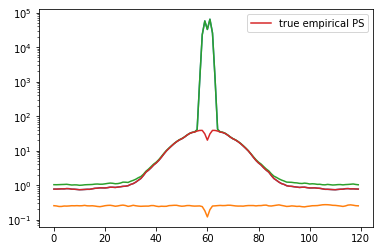

In [142]:
# looking at signal and noise spectra, for later comparison

pS = naivePS(Vft, meansub=1, taper=1)
pSsig = naivePS(signaltouse, meansub=1, taper=1)

# true (empirical) power spectrum - mean over signal power spectra
tps = np.mean(pSsig, axis=0).real

pSnoise = naivePS(noiseS, meansub=1, taper=1)
pSdata = naivePS(Vis_noise, meansub=1, taper=1)
plt.plot(np.mean(pS, axis=0))
plt.plot(np.mean(pSnoise, axis=0))
plt.plot(np.mean(pSdata, axis=0))
plt.plot(tps, label='true empirical PS')
plt.yscale('log')
plt.legend()

In [11]:
# now a load of functions for the different parts of the sampler

def sample_S(s=None, sk=None, prior=None):
    """
    Draw samples of the bandpowers of S, p(S|s). This assumes that the conditional 
    distribution for the bandpowers are uncorrelated with one another, i.e. the Fourier-
    space covariance S has no off-diagonals.
    
    Parameters:
        s (array_like):
            A set of real-space samples of the field, of shape (Ntimes, Nfreq).
    """
    if s is None and sk is None:
        raise ValueError("Must pass in s (real space) or sk (Fourier space) vector.")

    if sk is None:
        sk = np.fft.fft(s, axis=-1) 
    Nobs, Nfreqs = sk.shape
    
    beta = np.sum(sk * sk.conj(), axis=0).real 
    
    alpha = Nobs/2. - 1.
    
    x = np.zeros(Nfreqs)
    for i in range(Nfreqs):
        x[i] = invgamma.rvs(a=alpha) * beta[i] # y = x / beta
    
    
    
    if prior is not None:
        for i in range(Nfreqs):
            if prior[0,i] ==0: continue
            else: 
                if x[i] > prior[0,i]:  x[i] = prior[0,i]
                if x[i] < prior[1,i]:  x[i] = prior[1,i]
                    
    return x

In [150]:
def sprior(signals, bins, factor):
    
    # prior on cov samples 
    
    # bins - number of bins past zero delay to take, either side. e.g. bins=2 takes delays [-2,-1,0,1,2] from centre
    # factor is maximum factor to multiply / divide the truth by
    
    Nobs,Nfreq = signals.shape

    ds = nPS(signals)
    
    prior = np.zeros((2,Nfreq))
    
    prior[0] = ds*factor
    prior[1] = ds/factor
    
    prior[0,bins+1:-bins] = 0
    prior[1,bins+1:-bins] = 0
    
    return prior/(Nobs/2 -1)

In [13]:
def GCR_eig(dat, w, matlib, F_evecs, f0=None, amps=None):
    """
    
    GCR w/ fitted eigenmodes of C_foreground
    
    F_evecs --> matrix of foreground eigenvectors
    f0 --> mean of foregrounds
    matlib --> contains a load of matrices the GCR needs
    
    """
    s = F_evecs.shape[0]
    fvs = F_evecs.shape[1]
        
    d = dat.reshape((1,max(s,len(dat.T))))

    Sh = matlib[0][0]
    Si = matlib[0][1]
    Ni = matlib[0][2]
    Sih = matlib[0][3]
    Nih = matlib[0][4]
    A = matlib[1][0]
    Ai = matlib[1][1]
            
    omi, omj = np.random.randn(s,1),np.random.randn(s,1)
    omk, oml = np.random.randn(s,1),np.random.randn(s,1)
    oma, omb = (omi+1j*omj)/2**0.5 , (omk+1j*oml)/2**0.5

    b = np.zeros((s+fvs,1), dtype=complex)

    b[:s] = Ni @ (w*d).T + Sih@oma + Nih @ omb
    b[s:] = F.T.conj() @ (Ni @ (w*d).T + Nih @ omb) 
    
    if f0 is not None:
        xboth, info2 = conjgrad(A, b, maxiter=1e5, x0=np.concatenate((np.zeros(s,dtype=complex),f0)), M=Ai)
    else: 
        xboth, info2 = conjgrad(A, b, maxiter=1e5, M=Ai)
        
    sig_sol = xboth[:s]
    fg_sol = xboth[s:] @ F.T            

    sol = sig_sol + fg_sol
       

    if amps==True: return xboth
    else: return sig_sol

In [14]:
def makeS(delayspec):
    
    # transforms the sampled delay spectrum back into freq-freq for the next iter's C_signal
    
    N_freq = delayspec.size
    
    C_sigfft = np.zeros((N_freq, N_freq), dtype=complex)
    
    for i in range(N_freq):
        C_sigfft[i,i] = delayspec[i]
        
    C_sig = (FO.T.conj() @ C_sigfft @ FO).real
    
    return C_sig
    

In [15]:
def GCR_eigarray(V, w, matlib, F_evecs, f0=None, ncpu=2, amps=None):
    
    # performing the GCR step on all LSTs, uses parallelization 
    
    if amps: VC = np.zeros((V.shape[0],V.shape[1]+F_evecs.shape[1]), dtype=complex)
    else: VC = np.zeros(V.shape, dtype=complex)

    Vidxs = np.arange(V.shape[0])
    
    st=time.time()
    with Pool(ncpu) as pool:
        VC = pool.map(lambda idx: GCR_eig(V[idx], w, matlib, F_evecs, f0=f0, amps=amps), Vidxs)

    print('%.1fs'%(time.time()-st), end=' ')
    if amps: return np.array(VC).reshape((V.shape[0],-1))
    else: return np.array(VC).reshape(V.shape)

In [17]:
# the single iteration / step function

def Gibbs_eig_step(vis, S, F_evecs,  N, flags, f0=None, amps=None, prior=None, ncpu=2):
    
    Nvis,Nfreq = vis.shape
    
    fvs = F_evecs.shape[1]
    A_l = int(s + fvs) 
    
    matlib = [0,0]
    matlib[0] = np.zeros((5,Nfreq,Nfreq),dtype=complex)
    matlib[1] = np.zeros((2,A_l,A_l),dtype=complex)

    matlib[0][0] = sp.linalg.sqrtm( S ) # Sh
    matlib[0][1] = np.linalg.inv( S )   # Si
    matlib[0][2] = flags.T*np.linalg.inv( N )*flags # Ni
    matlib[0][3] = sp.linalg.sqrtm( matlib[0][1] )  # Sih
    matlib[0][4] = sp.linalg.sqrtm( matlib[0][2] )  # Nih
    
    A = np.zeros((A_l, A_l), dtype=complex)
    A[:s,:s] =  matlib[0][1] + matlib[0][2]  # Si + Ni
    A[:s,s:] = matlib[0][2] @ F_evecs     
    A[s:,:s] =  F_evecs.T.conj() @ matlib[0][2]  
    A[s:,s:] = F_evecs.T.conj() @ matlib[0][2] @ F_evecs

    matlib[1][0] = A
    matlib[1][1] = np.linalg.inv(A)
    
    cr = GCR_eigarray(vis, flags, matlib, F_evecs, f0=f0, ncpu=ncpu, amps=amps)
    if amps: 
        amplitudes = cr[:,-F_evecs.shape[1]:]
        cr = cr[:,:-F_evecs.shape[1]]
    
    ds_sample = sample_S(s=cr, prior=prior)
    
    Snew = makeS(ds_sample/(2*Nfreq**2)) # divide by factor of 2 * N_freq^2
    
    if amps: return cr, Snew, ds_sample, amplitudes
    else: return cr, Snew
    

In [ ]:
# setting the number of eigenvectors to use with the sampler

Sevals, Sevs = np.linalg.eig(C_f) 
Nf = 8
F = Sevs[:,:Nf]

In [144]:
# this is the data-generating cell where many things are set (notably not the SNR, which is close to the beginning)

Niter = 800    # number of iterations

np.random.seed()

name = 'run10'  
savfol = 'Gibbs-eig-runs/'

# initial 3 was pretty nice! definitely usable
# initial 4 now beginning with circulant matrix, a little different and worth looking at
# initial 5 running for 1k iters to make covariance over sampled vals
# initial 6 running with 5% cont. flag
# initial 7 2000 iters with 5% cont. flag, stopped at 1372
# initial 8 attempt with eor sims 400 iters
# initial 9 eor sims again, 200 iters, 12 eigenvectors
# initial 10 back on gaussian signal, 100 iters very low noise no flags - any oscillations? NONE! (or, at the 0.001% level)
# initial 11 100 iters. slightly less low noise, no flags - now has oscillations
# initial 12 600 iters - 5% flag normal noise, priors, x0=f0 - testing prior
# initial 13 400ix1200 as above but no ds prior, testing matlib - 
# initial 14 400iX1200 testing x0=f0, matlib, no dsprior - x0=f0 messed it up?
# initial 15 200ix1200 removed x0=f0, does that improve things - yes

# run1 - 1500ix1200, random 5% flag, hard prior - comparison to joint sampling: very nice, actually! not travelling
# run2 - 800ix1200 - paper run
# run3 - 800    10% cont run
# run4 - ''     5% cont.   SNR 5/1 - 
# run5 - ''     no flag    SNR 5/1 - 
#####
# run6 - ''     5% rand.   SNR  30/1- some larger scale oscillations in the recovery
# run7 - ''     none       SNR  30/1- delay spectrum has fewer oscillations
# run8 - ''     none       SNR   3/1- 
# run9 - ''     none       SNR 0.5/1-
# run-- ''     5% random  SNR   5/1- [prior is 1.5x too large]
# run10- ''     no flag    SNR   3/1- USING CFAINT! change back after (above under def eigarray,C_faint to C_f)

cr_store = np.zeros((Niter,Np,120), dtype=complex)   # output data arrays
S_store = np.zeros((Niter,120,120))
ds_store = np.zeros((Niter,120))
amp_store = np.zeros((Niter,Np,Nf),dtype=complex)

flagging = w0   # w0 = no flag, w1 / w2 / w3 random flags, wc1 / wc2 / wc3 continuous flags

# f0 = F.T.conj() @ np.mean(bl, axis=0)   # this sets the foreground mean, but I don't think it's necessary with this sampler
f0 = None
dsprior = sprior(signaltouse, bins=2, factor=1) # delay spectrum prior
# dsprior = None

# first iteration - I provide the correct covs
cr_store[0],S_store[0],ds_store[0],amp_store[0] = Gibbs_eig_step(Vis_noise*flagging, C_signalcirc, F, N, flagging, f0=None, amps=True,prior=dsprior)

# saving the signal and noise sims that were generated
np.save(savfol+'truesigs-'+name+'.npy',signaltouse)
np.save(savfol+'noise-'+name+'.npy',noiseS)


# for loop for the remaining iterations
for i in range(Niter-1):
    print('IT#%d'%(i+1),end=', ')
    
    cr_store[i+1] , S_store[i+1],ds_store[i+1],amp_store[i+1] = Gibbs_eig_step(Vis_noise*flagging, S_store[i], F, N, flagging, f0=None, amps=True,prior=dsprior)

#     if not i%500:               # saving every 500 iters for longer runs
#         np.save(savfol+'cr-'+name+'.npy',cr_store)
#         np.save(savfol+'S-'+name+'.npy',S_store)
#         np.save(savfol+'ds-'+name+'.npy',ds_store)
#         np.save(savfol+'amps-'+name+'.npy',amp_store)

np.save(savfol+'cr-'+name+'.npy',cr_store)
np.save(savfol+'S-'+name+'.npy',S_store)
np.save(savfol+'ds-'+name+'.npy',ds_store)
np.save(savfol+'amps-'+name+'.npy',amp_store)

0.8s IT#1, 0.8s IT#2, 0.8s IT#3, 0.8s IT#4, 0.8s IT#5, 0.8s IT#6, 0.9s IT#7, 0.8s IT#8, 0.8s IT#9, 0.7s IT#10, 0.8s IT#11, 0.8s IT#12, 0.8s IT#13, 0.8s IT#14, 0.8s IT#15, 0.8s IT#16, 0.8s IT#17, 0.8s IT#18, 1.0s IT#19, 0.8s IT#20, 0.9s IT#21, 0.8s IT#22, 0.9s IT#23, 0.8s IT#24, 0.8s IT#25, 0.8s IT#26, 0.8s IT#27, 0.8s IT#28, 0.8s IT#29, 0.8s IT#30, 0.8s IT#31, 0.9s IT#32, 0.9s IT#33, 0.8s IT#34, 0.8s IT#35, 0.8s IT#36, 0.9s IT#37, 0.8s IT#38, 0.8s IT#39, 0.8s IT#40, 0.9s IT#41, 0.8s IT#42, 0.8s IT#43, 0.8s IT#44, 0.9s IT#45, 0.9s IT#46, 0.9s IT#47, 0.9s IT#48, 0.8s IT#49, 0.9s IT#50, 0.8s IT#51, 0.8s IT#52, 0.8s IT#53, 0.8s IT#54, 0.8s IT#55, 0.8s IT#56, 0.8s IT#57, 0.8s IT#58, 0.8s IT#59, 0.8s IT#60, 0.8s IT#61, 0.8s IT#62, 0.8s IT#63, 0.8s IT#64, 0.8s IT#65, 0.9s IT#66, 0.9s IT#67, 0.8s IT#68, 0.8s IT#69, 0.8s IT#70, 0.8s IT#71, 0.8s IT#72, 0.8s IT#73, 0.9s IT#74, 0.8s IT#75, 0.9s IT#76, 0.8s IT#77, 0.8s IT#78, 0.8s IT#79, 0.8s IT#80, 0.8s IT#81, 0.8s IT#82, 0.9s IT#83, 0.8s IT#84, 0

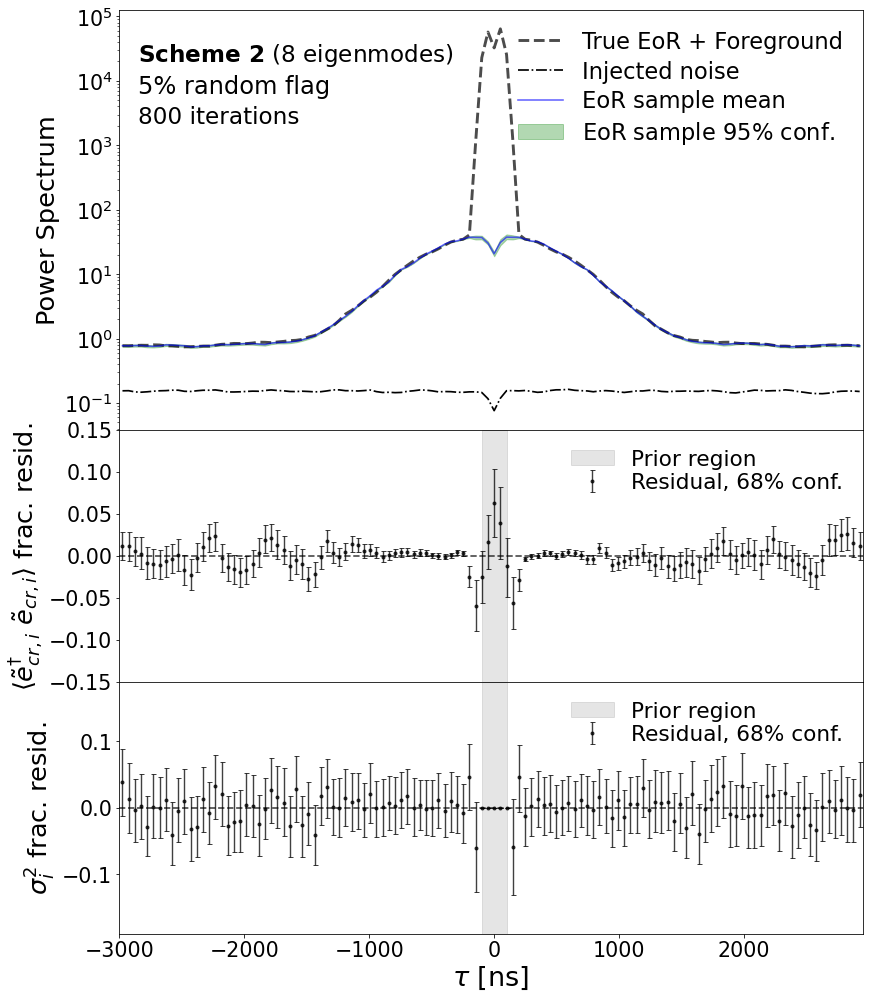

In [391]:
Niter=800
flagtag = '5% random flag'
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,14), sharex=True, gridspec_kw={'hspace':0, 'height_ratios':[1,0.6,0.6]})

fsb = 8.1
lwb = 0.5

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + Foreground', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'EoR sample 95$\%$ conf.')

erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')

erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

ax1.legend(frameon=False, fontsize=14.5+fsb, labelspacing=0.3, loc='upper right')
ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15)
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='upper right')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(labelsize=12.5+fsb)

ax1.text(-2850,2e4, r'$\bf{Scheme~2}$ (%d eigenmodes)'%F.shape[1], fontsize=15+fsb)
ax1.text(-2850,6.45e3, flagtag, fontsize=16+fsb)
ax1.text(-2850,22e2, '%d iterations'%Niter, fontsize=15+fsb)
# ax1.text(-2850,2e2, r'$\bf{15Jy~point~source~cut}$', fontsize=15+fsb)

ax1.set_ylabel(r'Power Spectrum', fontsize=17.5+fsb)
ax2.set_ylabel(r'$\langle \tilde e_{cr,i}^\dag ~\tilde e_{cr,i} \rangle$ frac. resid.', fontsize=17.5+fsb)
ax3.set_ylabel(r'$\sigma^2_i$ frac. resid.', fontsize=17.5+fsb)
ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)
plt.tight_layout()
# plt.savefig('figs/Gibbs/5r-5-em.pdf')

In [390]:
# loading in previous runs
name = 'run2'
savfol = 'Gibbs-eig-runs/'
cr_store = np.load(savfol+'cr-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
amp_store = np.load(savfol+'amps-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
pSnoise = naivePS(noiseS)

# Niter=cr_store.shape[0]

## Remainder is making other figures

In [342]:
cr_store.shape

(800, 1200, 120)

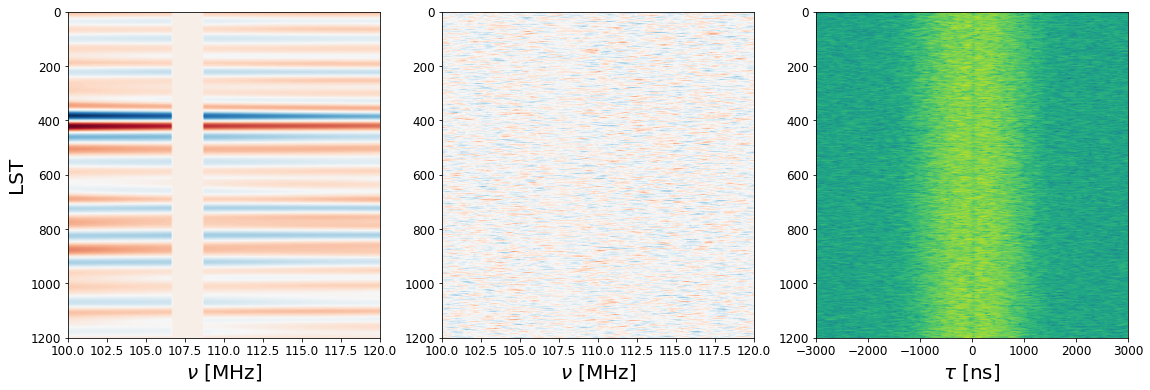

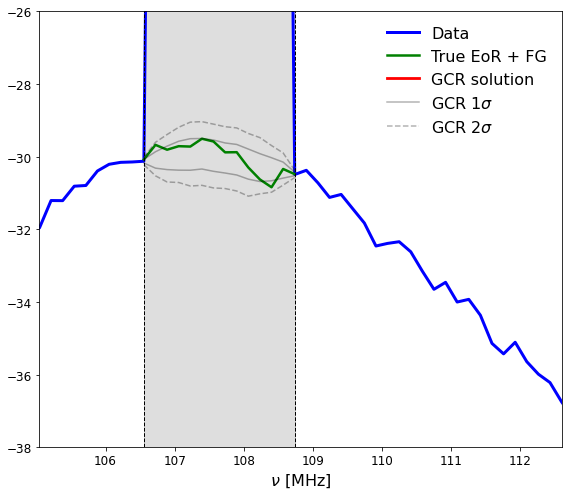

Text(0.5, 0, '$\\tau$ [ns]')

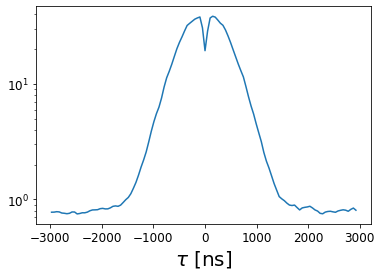

In [498]:
# waterfall, first iteration (using correct covariance)

# flagged data first, then inpainted data

# plot the flagged data as a waterfall

farr = range(39,53)

Vtrue = signaltouse + bl 

Vdat = (signaltouse + bl + noiseS)*wc3

# Vinp = cr_store[0,:] + amp_store[0,:]@F.T
Vinp = cr_store[0,:] 


Vinp_m = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 50, axis=0)
Vinp_1a = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 84, axis=0)
Vinp_1b = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 16, axis=0)
Vinp_2a = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 98, axis=0)
Vinp_2b = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 2, axis=0)


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(19,6), gridspec_kw={'hspace':0.12})
im1 = ax1.imshow(Vdat.real, aspect='auto', cmap='RdBu', extent=(100,120,1200,0))
im2 = ax2.imshow(Vinp.real, aspect='auto', cmap='RdBu', extent=(100,120,1200,0))
im3 = ax3.imshow(np.log(naivePS(Vinp, meansub=1, taper=1)), aspect='auto', cmap='viridis', extent=(-3000,3000,1200,0))
ax1.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax2.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=20)
ax1.set_ylabel('LST', fontsize=20)
# plt.colorbar(im1, ax=ax1, shrink=0.8)
# plt.colorbar(im2, ax=ax2, shrink=0.8)
for ax in [ax1,ax2, ax3]:
    ax.tick_params(labelsize=12)
# ax1.set_title('Flagged Data', fontsize=20)
# ax2.set_title('1 iteration: GCR solution', fontsize=20)
# plt.tight_layout()
plt.savefig('figs/Gibbs/waterfalleor.pdf', bbox_inches='tight')

# now let's look at an individual visibility

plt.show()
fig,ax=plt.subplots(figsize=(8,7))
plt.plot(nu_, Vdat.real[0], lw=3, label='Data', c='b')
plt.plot(nu_[farr], Vtrue.real[0][farr], lw=2.5, label='True EoR + FG', c='g')
# plt.plot(Vinp.real[0], lw=2.5, label='single GCR solution', ls='--')
plt.plot(nu_[farr], Vinp[0][farr].real, c='r', lw=2.8, label='GCR solution')
plt.plot(nu_[farr], Vinp_1a[farr].real, c='k', alpha=0.3, lw=1.5, label=r'GCR 1$\sigma$')
plt.plot(nu_[farr], Vinp_1b[farr].real, c='k', alpha=0.3,  lw=1.5)
plt.plot(nu_[farr], Vinp_2a[farr].real, c='k', alpha=0.3,  ls='--',lw=1.5, label=r'GCR 2$\sigma$')
plt.plot(nu_[farr], Vinp_2b[farr].real, c='k', alpha=0.3,  ls='--',lw=1.5)

# plt.plot(Vinp_av.real[0], lw=2.5, label='Mean EoR sample', ls='--')


plt.axvline(nu_[39], ls='--', c='k', lw=1)
plt.axvline(nu_[52], ls='--', c='k', lw=1)
plt.axvspan(nu_[39],nu_[52],color='k', alpha=0.13)
ax.tick_params(labelsize=12)
plt.xlim(nu_[30],nu_[75])
plt.ylim(-38, -26)
plt.legend(frameon=False, fontsize=16)
plt.xlabel(r'$\nu$ [MHz]', fontsize=16)
plt.tight_layout()
# plt.savefig('figs/Gibbs/inpaint.pdf')
plt.show()

plt.plot(tau_f*1e3, np.mean(naivePS(Vinp, meansub=1, taper=1), axis=0))
plt.yscale('log')
plt.tick_params(labelsize=12)
plt.xlabel(r'$\tau$ [ns]', fontsize=20)

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


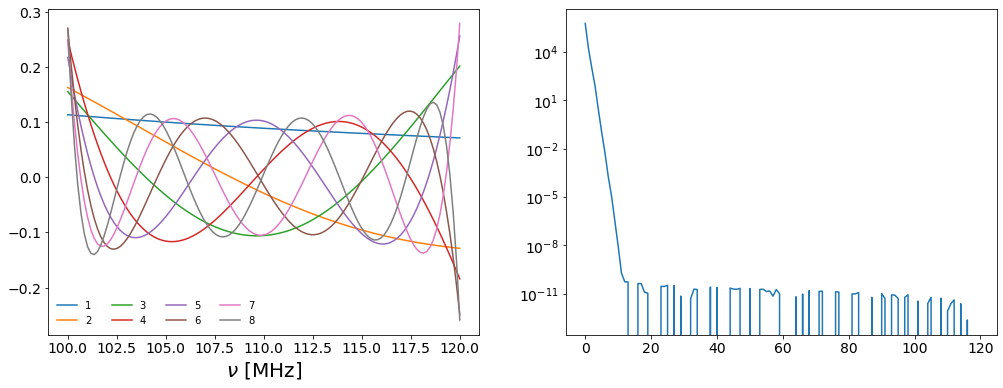

In [483]:
### plt.subplots(figsize=(12,8))
fig, (ax1,ax2) =plt.subplots(1,2, figsize=(17,6), gridspec_kw={'hspace':0.05})
for i in range(8):
    ax1.plot(nu_, F[:,i], label='%d'%(i+1))
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax1.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax1.legend(frameon=False, fontsize=10, ncol=4)
ax2.plot(Sevals)
ax2.set_yscale('log')

# plt.savefig('figs/Gibbs/eigenmodes.pdf')

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


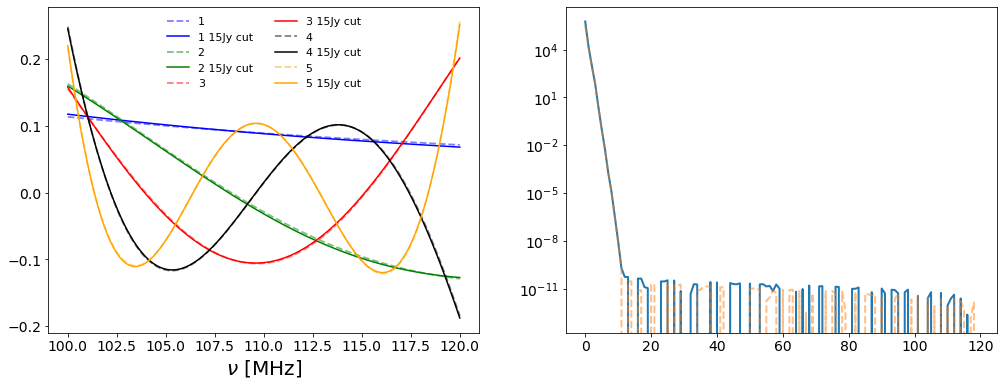

In [497]:
Sevals_f, Sevs_f = np.linalg.eig(C_faint) 
Nf = 8
F_faint = Sevs_f[:,:Nf]

fcols = ['b', 'g', 'r', 'k', 'orange']

fig, (ax1,ax2) =plt.subplots(1,2, figsize=(17,6), gridspec_kw={'hspace':0.05})
for i in range(5):
    ax1.plot(nu_, F[:,i], label='%d'%(i+1), alpha=0.5, lw=1.8,  ls='--', c=fcols[i])
    ax1.plot(nu_, F_faint[:,i], label='%d 15Jy cut'%(i+1), c=fcols[i])
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax1.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax1.legend(frameon=False, fontsize=11, ncol=2)
ax2.plot(Sevals, lw=2)
ax2.plot(Sevals_f, ls='--', alpha=0.5, lw=2)
ax2.set_yscale('log')

plt.savefig('figs/Gibbs/fainteigenmodes.pdf')

In [ ]:
### plt.subplots(figsize=(12,8))
fig, (ax1,ax2) =plt.subplots(1,2, figsize=(17,6), gridspec_kw={'hspace':0.05})
for i in range(8):
    ax1.plot(nu_, F[:,i], label='%d'%(i+1))
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax1.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax1.legend(frameon=False, fontsize=10, ncol=4)
ax2.plot(Sevals)
ax2.set_yscale('log')

plt.savefig('figs/Gibbs/eigenmodes.pdf')

In [ ]:
# trace plots to determine where it has converged
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(9,15))

for i in range(8):
    amptrace = np.sum(amp_store[:1300,:,i], axis=1).real
    ax1.plot(amptrace/amptrace[0], label='fg amp %d'%i,alpha=0.5)
    ampcorr = np.correlate(amptrace-np.mean(amptrace),amptrace-np.mean(amptrace),mode='full')
    ax2.plot(ampcorr/max(ampcorr), label='%d'%i)
# plt.yscale('log')
ax1.legend()
ax2.legend()

In [ ]:
# trace plots to determine where it has converged
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15))
traceidx =0
for idx in [0,1,2,3,4,5]:
    trace = ds_store[:,idx]
    ax1.plot(trace/trace[0], label='%d-delay PS'%idx)
    corr = np.correlate(trace-np.mean(trace),trace-np.mean(trace), mode='full')
    ax2.plot(corr/max(corr), label='%d'%idx)
    
# plt.plot(np.sum(crf_store[:,:,1], axis=1), label='fg amp')
# plt.yscale('log')
# plt.yscale('log')
ax1.legend()
ax2.legend()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,11))
ds_store.shape
np.sum(amp_store, axis=1).shape
covmax = 1e50
im = ax1.matshow(np.cov(ds_store.T, np.sum(amp_store, axis=1).T).real, cmap='RdBu', vmin=-1*covmax, vmax=covmax)
im2 = ax2.matshow(np.cov(ds_store.T, np.sum(amp_store, axis=1).T).imag, cmap='RdBu', vmin=-1*covmax, vmax=covmax)

plt.colorbar(im, ax=ax1, shrink=0.6)
plt.colorbar(im2, ax=ax2, shrink=0.6)

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

plt.plot(Vis_noise[0].real)
plt.plot(Vis_noise[0].imag)

plt.plot(cr_eig.real.T, ls='--', alpha=0.7, label='cr')
plt.plot(cr_eig.imag.T, ls='--', alpha=0.7, label='cr')

# plt.plot(cr_st.real.T, ls='--', alpha=0.7, label='cr')
# plt.plot(cr_st.imag.T, ls='--', alpha=0.7, label='cr')
plt.legend()